In [17]:
import numpy as np
import pandas as pd
import time 
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans

In [18]:
#make null if not within the first 250 stocks by the market cap
price_data = pd.read_csv('price_data_from_shardar.csv')
cap_data = pd.read_csv('cap_data_from_shardar.csv')
price_data = price_data.set_index(['date'])
cap_data = cap_data.set_index(['date'])
price_data.index = pd.to_datetime(price_data.index)
cap_data.index = pd.to_datetime(cap_data.index)


# for day in price_data.index.strftime('%Y-%m-%d').to_list():
#     small_cap  = cap_data.loc[day].sort_values(ascending=False)[cap_data.loc[day].sort_values(ascending=False).notnull()].index[500:].to_list()
#     for small_c in small_cap:
#         price_data.loc[day, small_c] = np.NaN
        
        

        
# #removing columns with only nulls
# all_null_cols = price_data.columns[price_data.isnull().sum()==price_data.shape[0]]
# print(all_null_cols)
# print(len(all_null_cols))
# price_data.drop(columns = all_null_cols, inplace = True)

#get SPY data
df = pd.DataFrame()
end_date = (price_data.index[-1]+ pd.DateOffset(1)).strftime('%Y-%m-%d')
start_date = price_data.index[0].strftime('%Y-%m-%d')

spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)

[*********************100%***********************]  1 of 1 completed


In [3]:
price_data.shape

(5787, 926)

In [19]:
df = pd.merge(price_data, spy_data, how='inner', left_index=True, right_index=True)

df_diff = df.diff()
df_diff = df_diff.loc[df_diff.index[1:]]
#################################################### betas

beta_wdw = 60

df_var = df_diff['SPY'].rolling(beta_wdw).var().dropna()

beta_df = {}

for stk in df.columns[:-1]:
    df_cov = df_diff[[stk, 'SPY']].rolling(beta_wdw).cov().unstack()[stk]['SPY']
    betas = (df_cov/(df_var))
    beta_df[stk] = betas

beta_df = pd.DataFrame(beta_df)    
    
beta_df = beta_df.loc[df_var.index]
df_diff = df_diff.loc[beta_df.index]

# all_null_cols = df_diff.columns[df_diff.isnull().sum()==df_diff.shape[0]].to_list()

# df_diff.drop(columns = all_null_cols, inplace = True)
# df.drop(columns = all_null_cols, inplace = True)

#################################################### Residuals
res_df = {}
for stk in df_diff.columns[:-1]:
    res_df[stk] = df_diff[stk]-beta_df[stk]*df_diff["SPY"]

res_df = pd.DataFrame(res_df)

del df_cov, betas, beta_df

print(res_df.shape)

(5727, 926)


In [381]:
res_df.head()

,AAMRQ,AAPL,ABS,ABT,ADBE,ADCT,ADI,ADM,ADP,ADSK,...,VICI,META,ON,ELV,CSGP,INVH,TRGP,ACGL,GEN,STLD
date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,-0.014807,-0.025409,1.271894,0.257632,0.049824,NaN,2.980169,0.031302,-0.412484,-0.822093,...,NaN,NaN,NaN,NaN,-0.232525,NaN,NaN,0.027371,-0.065038,-0.093977
2000-03-30,-0.998247,-0.053997,1.413913,0.223363,-0.647707,NaN,-4.294131,0.266549,0.286952,-0.195125,...,NaN,NaN,NaN,NaN,-0.128725,NaN,NaN,0.030080,0.038575,0.028410
2000-03-31,0.514399,0.060210,-0.183710,-0.120959,0.750312,NaN,0.941526,-0.091835,0.136774,0.218883,...,NaN,NaN,NaN,NaN,-0.040526,NaN,NaN,0.028162,0.128315,-0.029716
2000-04-03,0.288977,-0.026805,0.877817,0.447864,-1.554514,NaN,-4.360520,0.087166,0.706207,-0.386298,...,NaN,NaN,NaN,NaN,-0.024486,NaN,NaN,-0.038398,-0.647737,-0.060965
2000-04-04,0.296619,-0.033425,0.458676,0.669877,-0.738860,NaN,-1.519055,0.073836,0.677706,0.058093,...,NaN,NaN,NaN,NaN,-0.054557,NaN,NaN,0.058805,-0.160074,0.108566


In [20]:
price_pct = price_data.pct_change()
price_pct.head()

,AAMRQ,AAPL,ABS,ABT,ADBE,ADCT,ADI,ADM,ADP,ADSK,...,VICI,META,ON,ELV,CSGP,INVH,TRGP,ACGL,GEN,STLD
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,-0.022265,-0.083825,-0.013741,-0.028578,-0.083917,NaN,-0.050585,-0.009934,0.000000,-0.048777,...,NaN,NaN,NaN,NaN,0.031549,NaN,NaN,-0.005477,-0.046228,-0.055257
2000-01-05,-0.031285,0.014175,0.031861,-0.005657,0.017838,NaN,0.013091,-0.016111,-0.008465,-0.061195,...,NaN,NaN,NaN,NaN,-0.028730,NaN,NaN,0.092840,-0.062040,0.083266
2000-01-06,-0.026457,-0.086404,0.019294,0.039030,0.010146,NaN,-0.025953,0.005171,0.012202,-0.062682,...,NaN,NaN,NaN,NaN,-0.013995,NaN,NaN,-0.009359,-0.055395,0.004124
2000-01-07,0.025167,0.047288,0.011364,0.010514,0.048526,NaN,0.028201,0.016147,0.022838,0.118476,...,NaN,NaN,NaN,NaN,-0.015161,NaN,NaN,0.054506,0.079650,0.034354


In [21]:
begin = time.time() 

trade_date_list, trade_close_date_list, profit_plist = [], [], []
day_list = res_df.index
no_days = 5
trade_close_date_list.append(day_list[no_days-1])
for i, day in enumerate(res_df.index):
    if day not in trade_date_list and day==trade_close_date_list[-1] and i+3<=len(day_list)-1: #last condition is for the stopping criteria
        trade_day = day
        trade_date_list.append(trade_day)
        print(f"trade day = {trade_day.strftime('%Y-%m-%d')}")
        top_cap_list = cap_data.loc[trade_day].sort_values(ascending=False)[:300].index
        #if the residual has no null values then all stocks on this day have existed for last four days
        residuals_top = res_df.loc[day_list[i-no_days+1:i+1],top_cap_list]

        null_cols = residuals_top.columns[residuals_top.isnull().sum()>0]

        if len(null_cols)> 0:
            print(f'null columns = {residuals_top.columns[residuals_top.isnull().sum()>0]}')
            residuals_top.drop(columns = null_cols, inplace = True)
        res_begin_day = residuals_top.index[0].strftime('%Y-%m-%d')
        res_end_day = residuals_top.index[-1].strftime('%Y-%m-%d')
        print(f"residual day begin = {res_begin_day} end day = {res_end_day}")
        top_corr = abs(residuals_top.corr())
        corr_sum = top_corr.apply(lambda x: x.sum(axis=0))
        df_diag = np.diag(corr_sum)
        df_adja = top_corr.values
        df_lap = df_diag-df_adja
        K = 25 #number of clusters
        day_clus = KMeans(n_clusters=K,
                    random_state=2,
                    n_init=20).fit(LA.eig(df_lap)[1][:,0:K]).labels_
        ##################################################################################
        day_stocks_list = residuals_top.columns.values
        day_pct = price_pct.loc[residuals_top.index,day_stocks_list]
        day_winners, day_losers = [],[]
        cls_dic = {}
        unique_cls_list = np.unique(day_clus).tolist()
        for cls in np.unique(day_clus):
            stocks_in_cls = day_stocks_list[day_clus==cls]
            if len(stocks_in_cls) == 1:
                unique_cls_list.remove(cls)
                #print(f'one item cluster found on {day} for cluster {cls}')
                continue
            pct_in_cls = day_pct[stocks_in_cls]
            #calculate cluster mean and then deviations from mean
            deviations = pct_in_cls.apply(lambda x: x-x.mean(), axis=1)
            #taking the cumulative sum of all stocks deviations from cls mean
            cumsum_devi_stck_in_cls = deviations.apply(sum)
            #if the cumsum of stocks in cluster cls have deviated p amount from cluster mean
            p = 0
            winners = cumsum_devi_stck_in_cls[cumsum_devi_stck_in_cls>p].index.to_list()
            [day_winners.append(x) for x in winners]
            losers = cumsum_devi_stck_in_cls[cumsum_devi_stck_in_cls<-p].index.to_list()
            [day_losers.append(x) for x in losers]
            neutrals = cumsum_devi_stck_in_cls[cumsum_devi_stck_in_cls==p].index.to_list()
            #num_losers, num_winners for calculating weighted percentages 
            num_winners = len(winners)
            num_losers = len(losers)
            cls_dic[str(cls)+'_w'] =  winners
            cls_dic[str(cls)+'_l'] =  losers

        l, q = 1, 0.06
        total_gain = 0
        while (l < 4 and total_gain < q):
            print(l)
            cluster_gain = 0
            for cls in unique_cls_list:
                day_winners = cls_dic[str(cls)+'_w']
                day_losers = cls_dic[str(cls)+'_l']
                #note we ignore any stocks which are unavailable next day;could contains nulls in winners/losers pct below
                next_day_winners_pct = price_pct.loc[day_list[i+l],day_winners]
                next_day_win_pct = (next_day_winners_pct/(-len(day_winners)*len(unique_cls_list)*2)).sum()
                next_day_losers_pct = price_pct.loc[day_list[i+l],day_losers]
                next_day_los_pct = (next_day_losers_pct/(len(day_losers)*len(unique_cls_list)*2)).sum()
                cluster_gain = cluster_gain + next_day_win_pct + next_day_los_pct
            total_gain = (1+total_gain)*(1+cluster_gain)-1
            #print(f"day checked = {day_list[i+l].strftime('%Y-%m-%d')}")
            closed_day = day_list[i+l]
            l+=1
            print(cluster_gain)
            print(total_gain)
        trade_close_date_list.append(closed_day)
        profit_plist.append(total_gain)
        print(f"trade closed day  = {closed_day.strftime('%Y-%m-%d')}")
end = time.time()
print(f"Total runtime of the program is {(end - begin)/60} mins") 

trade day = 2000-04-04
null columns = Index(['PALM', 'EW', 'JHF'], dtype='object')
residual day begin = 2000-03-29 end day = 2000-04-04
1
0.010821048802093851
0.010821048802093891
2
0.017753761908963737
0.02876692503509548
3
0.0097219016544854
0.038768495905673994
trade closed day  = 2000-04-07
trade day = 2000-04-07
null columns = Index(['MET', 'EW', 'PALM', 'JHF'], dtype='object')
residual day begin = 2000-04-03 end day = 2000-04-07
1
0.0060503206495655035
0.006050320649565455
2
0.00941015920095139
0.015517414331046142
3
0.0057936681269389586
0.021400985206807555
trade closed day  = 2000-04-12
trade day = 2000-04-12
null columns = Index(['MET', 'JHF', 'PALM', 'EW'], dtype='object')
residual day begin = 2000-04-06 end day = 2000-04-12
1
0.005292310703280118
0.005292310703280068
2
-0.012570692548500191
-0.007344909855942161
3
0.006147224023566879
-0.0012428366386926237
trade closed day  = 2000-04-17
trade day = 2000-04-17
null columns = Index(['PALM', 'MET', 'JHF'], dtype='object')
res

In [22]:
len(profit_plist)

1907

In [27]:
profit_df  = pd.DataFrame()
profit_df['date'] = trade_close_date_list[1:]
profit_df['return'] = profit_plist
num_ave_returns = profit_df['date'].groupby([profit_df.date.dt.year]).agg('count').mean()
annualized_SR = np.sqrt(num_ave_returns)*profit_df['return'].mean()/profit_df['return'].std()
annualized_SR

0.7147455523504883

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

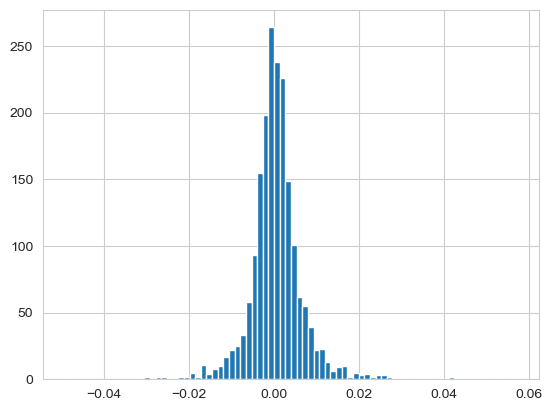

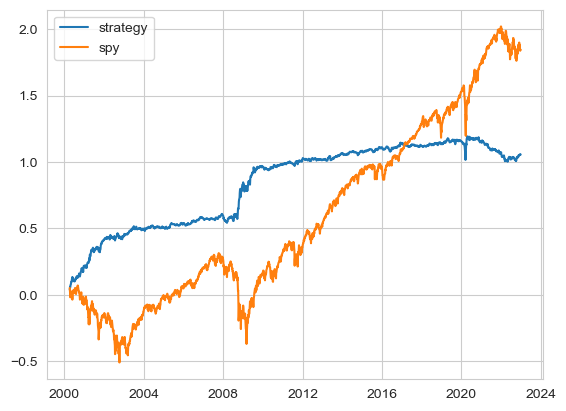

In [29]:
plt.hist(profit_plist, bins = 80)
plt.show()
profit_df.set_index(['date'], inplace=True)
spy_cumsum = spy_data.pct_change().cumsum().loc[profit_df.index]
profit_df['cumsum'] = profit_df['return'].cumsum()
plt.plot(profit_df['cumsum'])
plt.plot(spy_cumsum)
plt.legend(['strategy', 'spy'])
plt.show()

The code below is a try to implement non-step forward back testing strategy

In [118]:
for year in res_df.index.year.unique():
    this_year = res_df.loc[str(year)]
    all_null_cols = this_year.columns[this_year.isnull().sum()==this_year.shape[0]].to_list()
    this_year.drop(columns = all_null_cols, inplace = True)
    print(f'{this_year.shape[1]} stocks from {year}')
    ##include if condition to check if more than 500 stocks available
    w = 5
    df_corr = abs(this_year.rolling(w).corr())
    df_corr = df_corr.loc[df_corr.index[df_corr.shape[1]*(w-1):]] #remove first five days, note: this is multi index
    
    #need a for loop that runs daily-compute correlation matrix (remove nulls) and then laplacian and kmean     
     #We have to remove null columns and rows. Those were the stocks that were not available on a given date but
       # were added SPY in a future day in the same year
    for day in df_corr.index:
        print(day)
        break
    break    
    


435 stocks from 2000
(Timestamp('2000-04-04 00:00:00'), 'AAMRQ')


In [154]:
for day in df_corr.index:
    null_cols = df_corr.loc[day[0]].columns[(df_corr.loc[day[0]].isnull().sum()==df_corr.shape[1])]
    day_corr = df_corr.loc[day[0]].drop(columns = null_cols).drop(null_cols, axis=0)
    corr_sum = day_corr.apply(lambda x: x.sum(axis=0))
    df_diag = np.diag(corr_sum)
    df_adja = day_corr.values
    df_lap = df_diag-df_adja
    K = 3 #number of clusters
    day_clus = KMeans(n_clusters=K,
                random_state=2,
                n_init=20).fit(LA.eig(df_lap)[1][:,0:K]).labels_
    print(day_clus)
    break

[0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 2 0 0 2 0 0 0 2 2 2 0 0 0 0 0
 2 2 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0 0 0 2 0 0 0 0 2 2 0 0 2 0 2 0 0
 0 0 0 0 2 2 0 2 0 0 0 0 0 0 2 0 0 0 0 0 2 2 2 2 0 0 2 0 2 0 2 2 0 0 0 2 0
 0 0 0 0 2 0 0 0 2 2 0 0 0 0 0 0 0 0 2 2 2 2 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0
 0 0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 2 0 0 2 0 0 0 0 0 0 0 0 2 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 2 2
 0 1 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 2 0 2 2 0 0
 2 0 0 0 0 2 0 0 0 0 2 2 0 0 0 0 2 0 2 0 0 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]


In [147]:
day_corr

,AAMRQ,AAPL,ABS,ABT,ADBE,ADI,ADM,ADP,ADSK,AES,...,INCY,DISH,SNPS,CDNS,ZBRA,RTX,HWM,VTRS,PARA,GEN
AAMRQ,1.000000,0.654420,0.773944,0.019138,0.192364,0.404424,0.884657,0.155827,0.251685,0.876302,...,0.023249,0.131745,0.141778,0.143401,0.574887,0.693299,0.453675,0.256183,0.549435,0.267321
AAPL,0.654420,1.000000,0.853693,0.713009,0.725344,0.494206,0.866368,0.200644,0.490520,0.412564,...,0.360881,0.832990,0.783736,0.529496,0.923899,0.166047,0.801314,0.436544,0.908922,0.351830
ABS,0.773944,0.853693,1.000000,0.304488,0.464745,0.259908,0.782894,0.239048,0.767177,0.767732,...,0.591635,0.560195,0.655527,0.427309,0.867038,0.116776,0.890902,0.685773,0.600843,0.192870
ABT,0.019138,0.713009,0.304488,1.000000,0.765486,0.377258,0.388451,0.557087,0.174245,0.338468,...,0.218253,0.938811,0.783904,0.675883,0.614327,0.212442,0.472683,0.109672,0.779680,0.597522
ADBE,0.192364,0.725344,0.464745,0.765486,1.000000,0.788026,0.607553,0.692558,0.229593,0.075639,...,0.099999,0.855047,0.860108,0.816543,0.844103,0.243646,0.698962,0.535822,0.833775,0.844000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RTX,0.693299,0.166047,0.116776,0.212442,0.243646,0.233473,0.517328,0.010970,0.444222,0.459124,...,0.552068,0.310925,0.471891,0.717532,0.069998,1.000000,0.300748,0.497921,0.260380,0.708338
HWM,0.453675,0.801314,0.890902,0.472683,0.698962,0.335029,0.612613,0.029966,0.832569,0.473109,...,0.685083,0.745527,0.890674,0.782786,0.934051,0.300748,1.000000,0.877803,0.589315,0.601573
VTRS,0.256183,0.436544,0.685773,0.109672,0.535822,0.257787,0.335480,0.120425,0.797939,0.443083,...,0.633168,0.435657,0.701316,0.734361,0.719365,0.497921,0.877803,1.000000,0.229430,0.638723
PARA,0.549435,0.908922,0.600843,0.779680,0.833775,0.749024,0.866240,0.570572,0.117345,0.161519,...,0.018083,0.802671,0.685753,0.467747,0.831001,0.260380,0.589315,0.229430,1.000000,0.419255


In [149]:
df_lap.shape

(369, 369)

In [135]:
day_corr

,AAMRQ,AAPL,ABS,ABT,ADBE,ADI,ADM,ADP,ADSK,AES,...,INCY,DISH,SNPS,CDNS,ZBRA,RTX,HWM,VTRS,PARA,GEN
AAMRQ,1.000000,0.654420,0.773944,0.019138,0.192364,0.404424,0.884657,0.155827,0.251685,0.876302,...,0.023249,0.131745,0.141778,0.143401,0.574887,0.693299,0.453675,0.256183,0.549435,0.267321
AAPL,0.654420,1.000000,0.853693,0.713009,0.725344,0.494206,0.866368,0.200644,0.490520,0.412564,...,0.360881,0.832990,0.783736,0.529496,0.923899,0.166047,0.801314,0.436544,0.908922,0.351830
ABS,0.773944,0.853693,1.000000,0.304488,0.464745,0.259908,0.782894,0.239048,0.767177,0.767732,...,0.591635,0.560195,0.655527,0.427309,0.867038,0.116776,0.890902,0.685773,0.600843,0.192870
ABT,0.019138,0.713009,0.304488,1.000000,0.765486,0.377258,0.388451,0.557087,0.174245,0.338468,...,0.218253,0.938811,0.783904,0.675883,0.614327,0.212442,0.472683,0.109672,0.779680,0.597522
ADBE,0.192364,0.725344,0.464745,0.765486,1.000000,0.788026,0.607553,0.692558,0.229593,0.075639,...,0.099999,0.855047,0.860108,0.816543,0.844103,0.243646,0.698962,0.535822,0.833775,0.844000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RTX,0.693299,0.166047,0.116776,0.212442,0.243646,0.233473,0.517328,0.010970,0.444222,0.459124,...,0.552068,0.310925,0.471891,0.717532,0.069998,1.000000,0.300748,0.497921,0.260380,0.708338
HWM,0.453675,0.801314,0.890902,0.472683,0.698962,0.335029,0.612613,0.029966,0.832569,0.473109,...,0.685083,0.745527,0.890674,0.782786,0.934051,0.300748,1.000000,0.877803,0.589315,0.601573
VTRS,0.256183,0.436544,0.685773,0.109672,0.535822,0.257787,0.335480,0.120425,0.797939,0.443083,...,0.633168,0.435657,0.701316,0.734361,0.719365,0.497921,0.877803,1.000000,0.229430,0.638723
PARA,0.549435,0.908922,0.600843,0.779680,0.833775,0.749024,0.866240,0.570572,0.117345,0.161519,...,0.018083,0.802671,0.685753,0.467747,0.831001,0.260380,0.589315,0.229430,1.000000,0.419255


In [ ]:
    
df_diag = df_corr.groupby("date").apply(lambda x: np.diag(x.sum(axis=0)))
df_adja = df_corr.groupby("date").apply(lambda x: x.values)
df_lap = df_diag-df_adja 

In [83]:
this_year.shape

(192, 435)

In [85]:
df_lap

(188,)

In [91]:
df_lap[0]

array([[159.89384186,  -0.65441959,  -0.77394399, ...,  -0.54943509,
                 nan,  -0.2673205 ],
       [ -0.65441959, 175.27927035,  -0.85369261, ...,  -0.9089219 ,
                 nan,  -0.35183029],
       [ -0.77394399,  -0.85369261, 178.71812751, ...,  -0.60084305,
                 nan,  -0.19286984],
       ...,
       [ -0.54943509,  -0.9089219 ,  -0.60084305, ..., 164.65354189,
                 nan,  -0.41925522],
       [         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [ -0.2673205 ,  -0.35183029,  -0.19286984, ...,  -0.41925522,
                 nan, 173.12040913]])

In [97]:
df_corr.loc['2000-04-04']

,AAMRQ,AAPL,ABS,ABT,ADBE,ADI,ADM,ADP,ADSK,AEP,...,TFC,ZBRA,RTX,HWM,VTRS,TRMB,TECH,PARA,ON,GEN
AAMRQ,1.000000,0.654420,0.773944,0.019138,0.192364,0.404424,0.884657,0.155827,0.251685,NaN,...,NaN,0.574887,0.693299,0.453675,0.256183,NaN,NaN,0.549435,NaN,0.267321
AAPL,0.654420,1.000000,0.853693,0.713009,0.725344,0.494206,0.866368,0.200644,0.490520,NaN,...,NaN,0.923899,0.166047,0.801314,0.436544,NaN,NaN,0.908922,NaN,0.351830
ABS,0.773944,0.853693,1.000000,0.304488,0.464745,0.259908,0.782894,0.239048,0.767177,NaN,...,NaN,0.867038,0.116776,0.890902,0.685773,NaN,NaN,0.600843,NaN,0.192870
ABT,0.019138,0.713009,0.304488,1.000000,0.765486,0.377258,0.388451,0.557087,0.174245,NaN,...,NaN,0.614327,0.212442,0.472683,0.109672,NaN,NaN,0.779680,NaN,0.597522
ADBE,0.192364,0.725344,0.464745,0.765486,1.000000,0.788026,0.607553,0.692558,0.229593,NaN,...,NaN,0.844103,0.243646,0.698962,0.535822,NaN,NaN,0.833775,NaN,0.844000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRMB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TECH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PARA,0.549435,0.908922,0.600843,0.779680,0.833775,0.749024,0.866240,0.570572,0.117345,NaN,...,NaN,0.831001,0.260380,0.589315,0.229430,NaN,NaN,1.000000,NaN,0.419255
ON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
null_cols = df_corr.loc['2000-04-04'].columns[(df_corr.loc['2000-04-04'].isnull().sum()==435)]
df_corr.loc['2000-04-04'].drop(columns = null_cols).drop(null_cols, axis=0)

,AAMRQ,AAPL,ABS,ABT,ADBE,ADI,ADM,ADP,ADSK,AES,...,INCY,DISH,SNPS,CDNS,ZBRA,RTX,HWM,VTRS,PARA,GEN
AAMRQ,1.000000,0.654420,0.773944,0.019138,0.192364,0.404424,0.884657,0.155827,0.251685,0.876302,...,0.023249,0.131745,0.141778,0.143401,0.574887,0.693299,0.453675,0.256183,0.549435,0.267321
AAPL,0.654420,1.000000,0.853693,0.713009,0.725344,0.494206,0.866368,0.200644,0.490520,0.412564,...,0.360881,0.832990,0.783736,0.529496,0.923899,0.166047,0.801314,0.436544,0.908922,0.351830
ABS,0.773944,0.853693,1.000000,0.304488,0.464745,0.259908,0.782894,0.239048,0.767177,0.767732,...,0.591635,0.560195,0.655527,0.427309,0.867038,0.116776,0.890902,0.685773,0.600843,0.192870
ABT,0.019138,0.713009,0.304488,1.000000,0.765486,0.377258,0.388451,0.557087,0.174245,0.338468,...,0.218253,0.938811,0.783904,0.675883,0.614327,0.212442,0.472683,0.109672,0.779680,0.597522
ADBE,0.192364,0.725344,0.464745,0.765486,1.000000,0.788026,0.607553,0.692558,0.229593,0.075639,...,0.099999,0.855047,0.860108,0.816543,0.844103,0.243646,0.698962,0.535822,0.833775,0.844000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RTX,0.693299,0.166047,0.116776,0.212442,0.243646,0.233473,0.517328,0.010970,0.444222,0.459124,...,0.552068,0.310925,0.471891,0.717532,0.069998,1.000000,0.300748,0.497921,0.260380,0.708338
HWM,0.453675,0.801314,0.890902,0.472683,0.698962,0.335029,0.612613,0.029966,0.832569,0.473109,...,0.685083,0.745527,0.890674,0.782786,0.934051,0.300748,1.000000,0.877803,0.589315,0.601573
VTRS,0.256183,0.436544,0.685773,0.109672,0.535822,0.257787,0.335480,0.120425,0.797939,0.443083,...,0.633168,0.435657,0.701316,0.734361,0.719365,0.497921,0.877803,1.000000,0.229430,0.638723
PARA,0.549435,0.908922,0.600843,0.779680,0.833775,0.749024,0.866240,0.570572,0.117345,0.161519,...,0.018083,0.802671,0.685753,0.467747,0.831001,0.260380,0.589315,0.229430,1.000000,0.419255


In [115]:
null_cols

Index(['AEP', 'CB', 'CIN', 'CMS', 'CNP', 'ECL', 'EMN', 'ETR', 'ETS', 'EXC',
       'FPC', 'GPU', 'HAS', 'HM', 'HRB', 'MKG', 'NOC', 'PCAR', 'PEG', 'PPL',
       'TMC.A', 'TMO', 'TNB', 'TROW', 'VSTNQ', 'JNS', 'CIT.A', 'PALM', 'KSE',
       'DVN', 'PWER', 'EOG', 'HOT', 'RHI', 'AYE', 'MET', 'JHF', 'AWE', 'FDO',
       'IMNX', 'EOP', 'APOL', 'NFB', 'DGX', 'LH', 'NOV', 'WFM', 'BRL', 'LM',
       'PCP', 'NBL', 'APH', 'PWR', 'ROST', 'CERN', 'ALXN', 'VRTX', 'UHS',
       'MGM', 'SBAC', 'NKTR', 'GL', 'TFC', 'TRMB', 'TECH', 'ON'],
      dtype='object')

In [101]:
df_corr.shape

(81780, 435)

In [41]:

# #################################################### correlation calculation
w = 5

df_corr = abs(res_df.rolling(w).corr())

print(df_corr.shape) #number of rows  = number_rows_res_df*num_cols-(w-1)*num_cols

(5787, 866)

In [42]:
res_df.shape

(5727, 865)